In [1]:
import torch
import random
import pickle
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sidemethods import load_richardson_data, convert_to_float
from PIL import Image
from scipy.stats import spearmanr
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# local path to model repository on our servers
server_model_path = "/mounts/data/corp/huggingface/"
# loading the original human data as vectors for each action word
_, richardson_data, richardson_normed = load_richardson_data()
action_words = richardson_normed.keys()

In [2]:
from huggingface_hub import login

with open("../../hf.key", "r") as f_in:
    hf_key = f_in.readline().strip()

login(token = hf_key)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /mounts/data/corp/huggingface/token
Login successful


## Choosing Model

In [3]:
#model_name = "meta-llama/Llama-2-7b-hf"
#model_name = "meta-llama/Llama-2-7b-chat-hf"
model_name = "meta-llama/Llama-2-13b-hf"

## Choosing GPU

In [4]:
# Define the GPU ID you want to use
gpu_id = 3

# Use the torch.cuda.device() context manager to set the current GPU
with torch.cuda.device(gpu_id):
    tokenizer = AutoTokenizer.from_pretrained(model_name) # use_auth_token=True
    model = AutoModelForCausalLM.from_pretrained(server_model_path+model_name).to(torch.device("cuda")) # use_auth_token=True

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 100.00 MiB (GPU 3; 47.54 GiB total capacity; 47.14 GiB already allocated; 27.25 MiB free; 47.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Running experiment

The order with which the options are presented ['↑', '↓', '←', '→'] or ['←', '→', '↑', '↓'] matters for the model's choice. Hence, all 4! (24) permutations of the options are presented in order to create a sample distribution, which can be compared against the human responses.

In [ ]:
model_choices = dict()
arrows = ['↑', '↓', '←', '→']


with open("results/exp_UNICODE_"+model_name.split("/")[1]+"_responses.txt", "w") as f_out:
    for action_word in tqdm(action_words): # action_words:#

        if action_word == 0:
            continue

        ### PROMPT DEFINED HERE
        for arrow_list in list(itertools.permutations(arrows)):
            
            prompt = "Select the arrow that best represents the following event: "+action_word+". Choose one of these arrows: "+", ".join(arrow_list)+" and explain your choice. The best representation for "+action_word+" is:"
            
            input_ids = tokenizer.encode(prompt, return_tensors="pt").to(torch.device("cuda:"+str(gpu_id)))
            max_length = input_ids.size(1)  + 5
            output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, top_k=1)
            generated_answer = tokenizer.decode(output[0], skip_special_tokens=True)  
            counted = False
            if action_word not in model_choices.keys():
                model_choices[action_word] = [0,0,0,0]
            
            for idx, arrow in enumerate(arrows):
                if arrow in generated_answer[len(prompt):]:
                    model_choices[action_word][idx]+=1
                    counted = True

            if sum(model_choices[action_word]) > 24:
                print("Too many arrows in response.")

            f_out.write(action_word+"\t"+", ".join(arrow_list)+"\t"+generated_answer[len(prompt):]+"\n")

print(model_choices)

100%|██████████| 30/30 [02:47<00:00,  5.58s/it]

{'fled': [0, 24, 0, 0], 'pointed at': [2, 0, 22, 0], 'pulled': [0, 24, 0, 0], 'pushed': [0, 24, 0, 0], 'walked': [0, 24, 0, 0], 'hunted': [0, 24, 0, 0], 'impacted': [0, 24, 0, 0], 'perched': [6, 18, 0, 0], 'showed': [7, 17, 0, 0], 'smashed': [0, 24, 0, 0], 'bombed': [0, 24, 0, 0], 'flew': [0, 24, 0, 0], 'floated': [0, 24, 0, 0], 'lifted': [24, 0, 0, 0], 'sank': [0, 24, 0, 0], 'argued with': [0, 9, 15, 0], 'gave to': [0, 18, 6, 0], 'offended': [0, 24, 0, 0], 'rushed': [0, 23, 0, 1], 'warned': [0, 7, 17, 0], 'owned': [0, 20, 4, 0], 'regretted': [0, 21, 3, 0], 'rested': [0, 24, 0, 0], 'tempted': [0, 21, 3, 0], 'wanted': [7, 13, 4, 0], 'hoped': [14, 6, 4, 0], 'increased': [24, 0, 0, 0], 'obeyed': [0, 24, 0, 0], 'respected': [24, 0, 0, 0], 'succeeded': [18, 0, 6, 0]}


## Storing experimental results

In [6]:
to_store = input("Should the result for "+model_name+" be stored? (y/n):")

if to_store == "y":

    with open("results/exp_UNICODE_"+model_name.split("/")[1]+".txt", "w") as f_out:
        f_out.write("Action\tUP\tDOWN\tLEFT\tRIGHT\n")
        for k,v in model_choices.items():
            f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")
    

## Loading and evaluating results

Evaluation has three parts:
* The cosine similarity is reported between model and human choice and within constructs (6: abstract-horizontal, abstract-neutral ... concrete-vertical)
* Cohen's Kappa is evaluated to test the agreement between human and model
* Each choice distribution is visually displayed

In [7]:
model_choices = dict()
with open("results/exp_UNICODE_"+model_name.split("/")[1]+".txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

### Cosine similarity (within and out of constructs)

In [8]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5): # every 5th item is a different construct 
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.05146904230736511, 'pointed at': 0.007278240654795813, 'pulled': 0.07015614366807767, 'pushed': 0.04073524296805518, 'walked': 0.052927614362348704, 'hunted': 0.28353988292099275, 'impacted': 0.5714770833912031, 'perched': 0.9803908480843456, 'showed': 0.20355618448498952, 'smashed': 0.9168847249171459, 'bombed': 0.9953971353008849, 'flew': 0.736516786215887, 'floated': 0.8563849533194365, 'lifted': 0.9936284354654159, 'sank': 0.953734413319121, 'argued with': 0.2711411193924587, 'gave to': 0.11596243631618548, 'offended': 0.5891480944958387, 'rushed': 0.2137402120754433, 'warned': 0.21158169537732907, 'owned': 0.9337504636194525, 'regretted': 0.5497691216133497, 'rested': 0.6423687395005079, 'tempted': 0.31452344929674636, 'wanted': 0.2727682209377561, 'hoped': 0.8306305402849959, 'increased': 0.9799102451987528, 'obeyed': 0.06065887998911997, 'respected': 0.8581257823662447, 'succeeded': 0.7342838400698647}
{'Horizontal': 0.0339, 'Neutral': 0.4078, 'Vertical': 0.7164, 'Hor

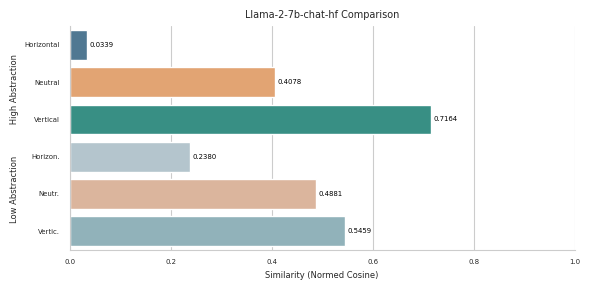

In [9]:
data = similarity_scores_constructs
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

plt.figure(figsize=(6, 3))
sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=6)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=6)
plt.title(model_name.split("/")[1]+' Comparison', fontsize=7)

for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=5, color='black')

plt.xlim(0, 1)
sns.despine()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.savefig("results/exp_UNICODE_"+model_name.split("/")[1]+"_CosSim.png")
plt.show()


In [10]:
average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
print("Average similarity between human choice and model choices is: ", round(average_sim,5))

# Write the average similarity to a text file with the name of the model
# Model name is the first part of the line in the file
# Check if entry for current model already exists, else append

with open("results/average_similarities.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/average_similarities.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+str(average_sim)+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+str(average_sim)+"\n")



Average similarity between human choice and model choices is:  0.40502


### Important: The model choice percentage is dividing all choices by 24 (number of all permutations)
Because if we only consider the total number of given responses, we do not penalize the fact that for some questions, no valid response has been given

In [11]:
print("Human % distrib.:", richardson_data)
print("Model distrib.:", model_choices)
model_percentages = {k:[round(100*(x/24),5) for x in entries] for k, entries in model_choices.items()}
print("Model % distrib.:", model_percentages)

Human % distrib.: {'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2], 'pulled': [6.0, 5.4, 75.4, 13.2], 'pushed': [7.2, 3.6, 1.2, 88.0], 'walked': [9.0, 3.6, 24.0, 62.9], 'hunted': [9.6, 20.4, 1.8, 68.3], 'impacted': [7.2, 37.1, 3.0, 52.7], 'perched': [12.0, 76.0, 6.6, 5.4], 'showed': [15.0, 9.0, 10.2, 65.9], 'smashed': [3.6, 66.5, 1.2, 28.7], 'bombed': [4.8, 86.8, 1.8, 6.6], 'flew': [37.7, 44.3, 15.0, 3.0], 'floated': [32.9, 56.3, 7.8, 3.0], 'lifted': [87.4, 9.6, 2.4, 0.6], 'sank': [22.2, 71.9, 4.2, 1.8], 'argued with': [11.4, 13.8, 12.6, 62.3], 'gave to': [8.4, 9.6, 1.2, 80.8], 'offended': [9.0, 31.7, 24.6, 34.7], 'rushed': [10.2, 10.8, 23.4, 55.1], 'warned': [10.8, 22.2, 6.0, 61.1], 'owned': [5.4, 55.7, 18.6, 20.4], 'regretted': [19.8, 24.0, 41.3, 15.0], 'rested': [14.4, 36.5, 40.1, 9.0], 'tempted': [16.8, 11.4, 45.5, 26.3], 'wanted': [15.6, 7.8, 15.6, 61.1], 'hoped': [45.5, 15.6, 7.2, 31.7], 'increased': [73.7, 7.2, 9.6, 9.0], 'obeyed': [22.8, 4.2, 64.7, 8.4], 'res

## Spearman R

In [12]:
# Assuming you have two dictionaries: model_percentages and richardson_data
concepts = ["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢']
spearmanr_values = {}

for concept in concepts:
    model_values = [model_percentages[key][concepts.index(concept)] for key in model_percentages]
    richardson_values = [richardson_data[key][concepts.index(concept)] for key in richardson_data]

    spearmanr_result = spearmanr(model_values, richardson_values)
    spearmanr_values[concept] = spearmanr_result.correlation, spearmanr_result.pvalue

In [13]:
# load spearmanr dict from file if it exists, else create new dict
try:
    with open("results/spearmanr_values.pkl", "rb") as f_in:
        spearmanr_values = pickle.load(f_in)
except:
    spearmanr_values = {model_name.split("/")[1]:spearmanr_values}


In [14]:
if model_name.split("/")[1] not in spearmanr_values.keys():
    spearmanr_values[model_name.split("/")[1]] = spearmanr_values

with open("results/spearmanr_values.pkl", "wb") as f_out:
    pickle.dump(spearmanr_values, f_out)

spearmanr_values

{'Llama-2-7b-hf': {'C:◯↑▢': (0.4366570499070509, 0.015841463144176563),
  'D:◯↓▢': (0.11238208039450244, 0.5543430494025304),
  'B:◯←▢ ': (0.090006317150778, 0.6362137325139334),
  'A:◯→▢': (-0.03178420121835632, 0.8675795315545534)},
 'Llama-2-7b-chat-hf': {...}}

## Visualization of Choice Distribution

/tmp/ipykernel_686942/290202722.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


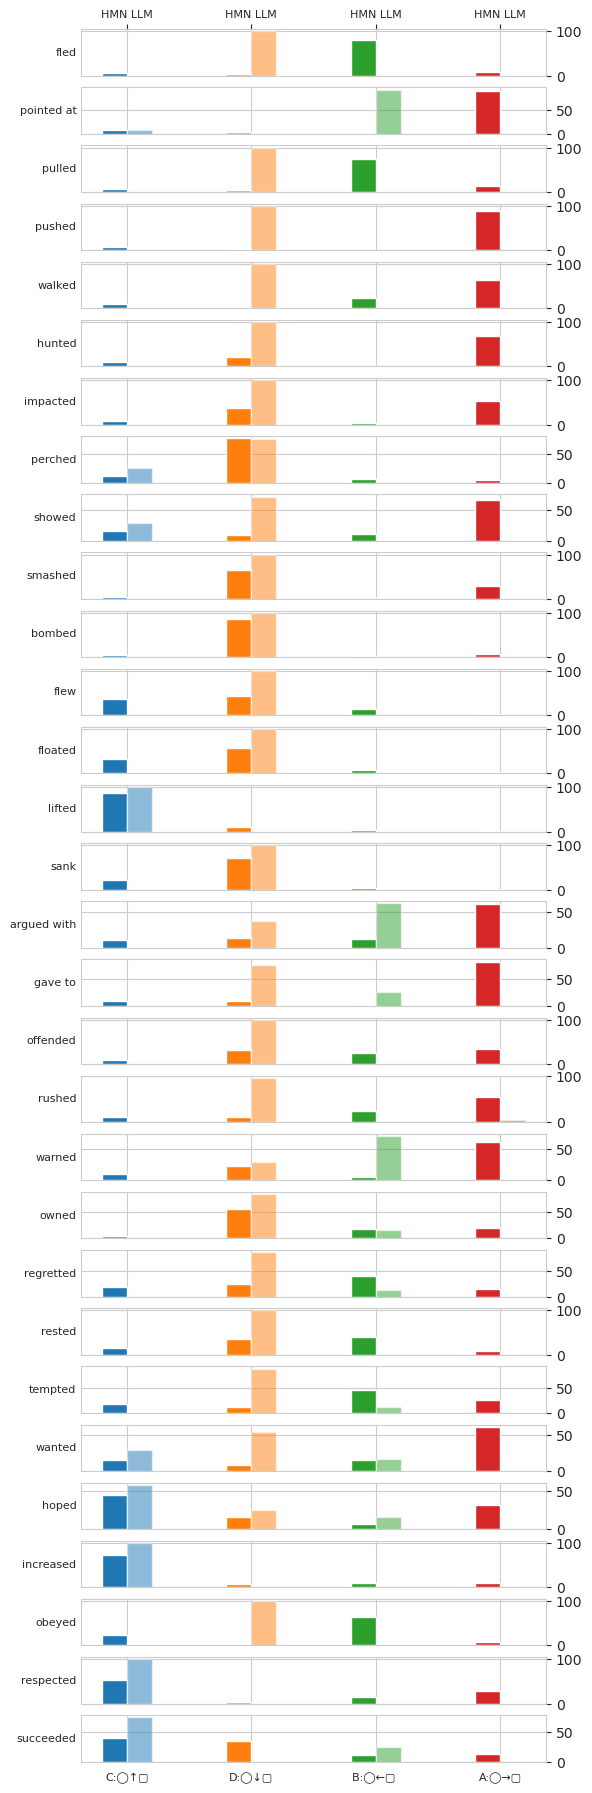

In [15]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_data
data_new = model_percentages

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.2  # Width of the old bars
bar_width_new = bar_width_old /2  # Width of the new bars

for i, action in enumerate(action_names):

    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots) 
    positions_new = positions_old + bar_width_old  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        color_A = colors[j]

        ax.bar(positions_old[j]-.1, value_old, bottom=bottom_old[j], width=bar_width_old, color=color_A)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j]-.1, value_new, bottom=bottom_new[j], width=bar_width_new*2, color=color_A, alpha=0.5)
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢'], fontsize=8)  # Adjust fontsize as needed
    if i == 0 :
        ax.set_xticklabels(["HMN LLM", 'HMN LLM', 'HMN LLM', 'HMN LLM'], fontsize=8)  # Adjust fontsize as needed
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("results/exp_UNICODE_"+model_name.split("/")[1]+"_Choices.png")
plt.show()
